In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import torch
from torch import nn
from torchvision.datasets import FashionMNIST, MNIST, CIFAR10
from torchvision import transforms as tv
from torchvision.models import resnet18, ResNet
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from cond_resnet import cond_resnet18, CondResnet
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
ds = CIFAR10('data/c10', train=True, target_transform=None, download=True, transform=tv.ToTensor()) # transform the data from PIL image to a tensor
ds_test = CIFAR10('data/c10', train=False, target_transform=None, download=True, transform=tv.ToTensor()) # transform the data from PIL image to a t

Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_size=64

train_dl = DataLoader(ds, batch_size, shuffle=True)
valid_dl = DataLoader(ds_test, batch_size, shuffle=True)

In [54]:
def train_step_regular(
    X, y, net, opt, loss_fn
) -> float:
    opt.zero_grad()
    y_pred = net(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    opt.step()
    return loss.item()

def train_step_cond(
    X, y, net, opt, loss_fn,
    max_k: int = 64,
    n_samples = 10
):
    opt.zero_grad()
    loss_total = 0
    samples = np.arange(1, max_k)
    np.random.shuffle(samples)
    samples = samples[:n_samples]
    loss = 0
    for k in samples:
        y_pred = net(X, k=k)
        loss += loss_fn(y_pred, y)
        
    loss.backward()
    opt.step()
    return loss.item()

def val_metrics(dl, net, loss_fn, k=None):
    val_losses = []
    y_predicted = []
    y_true = []

    with torch.no_grad():
        for iteration, (X_val, y_val) in enumerate(dl):

            X_val, y_val = [t.to(device) for t in [X_val, y_val]]
            
            if isinstance(net, CondResnet):
                assert isinstance(k, int)
                y_pred = net(X_val, k=k)
            elif isinstance(net, ResNet):
                y_pred = net(X_val)
            loss = loss_fn(y_pred, y_val)
            val_losses.append(loss.item())
            y_pred = y_pred.argmax(dim=1)
            y_true.extend(y_val.cpu().numpy())
            y_predicted.extend(y_pred.cpu().numpy())

        val_acc = accuracy_score(y_true, y_predicted)
    return val_acc, np.mean(val_losses)

def train_net(net, number_of_epochs = 10):
    
    net = net.to(device)
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(net.parameters())
    
    metrics_list = []
    for i in range(number_of_epochs):
        train_loss = 0
        for iteration, (X_train, y_train) in enumerate(train_dl):
            
            X_train, y_train = [t.to(device) for t in [X_train, y_train]]

            if isinstance(net, CondResnet):
                loss_step = train_step_cond(X_train, y_train, net, opt, loss_fn)
            elif isinstance(net, ResNet):
                loss_step = train_step_regular(X_train, y_train, net, opt, loss_fn)

        
            
        if isinstance(net, CondResnet):
            metrics = dict()
            for k in sorted(list(set(range(1, 64, 8))) + [64]):
                train_acc, train_loss = val_metrics(train_dl, net, loss_fn, k=k)
                val_acc, val_loss = val_metrics(valid_dl, net, loss_fn, k=k)
                metrics[k] = {
                    "train_loss": train_loss,
                    "train_acc": train_acc,
                    "val_loss": val_loss,
                    "val_acc": val_acc
                }
        elif isinstance(net, ResNet):
            train_acc, train_loss = val_metrics(train_dl, net, loss_fn)
            val_acc, val_loss = val_metrics(valid_dl, net, loss_fn)
            metrics = {64: {
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            }}

        print(f'#Epoch: {i}, metrics: {metrics}')
        metrics_list.append(metrics)
    return metrics_list

In [87]:
def plot_metrics(ml, show_train: bool = False):
    channels = ml[0].keys()
    fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
    ax[0].set_title("Loss")
    ax[1].set_title("Accuracy")
    
    
    folds_markers = {
        "val": "o"
    }
    if show_train:
        folds_markers["train"] = "^"
    for c in sorted(channels):
        
        alpha = (c+30) / (64+30)
        for fold, marker in folds_markers.items():
            mn = f"{fold}_loss"
            ax[0].plot(list(range(len(ml))), [m[c][mn] for m in ml], label=f"{mn} @ {c}", marker=marker, alpha=alpha)
        
        for fold, marker in folds_markers.items():
            mn = f"{fold}_acc"
            ax[1].plot(list(range(len(ml))), [m[c][mn] for m in ml], label=f"{mn} @ {c}", marker=marker, alpha=alpha)
        
    [
        a.legend(
            loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5    
        ) 
    for a in ax]


In [47]:
classic_r18 = resnet18()
m_r18 = train_net(classic_r18, 5)

Text(0.5, 0.98, 'Classic resnet')

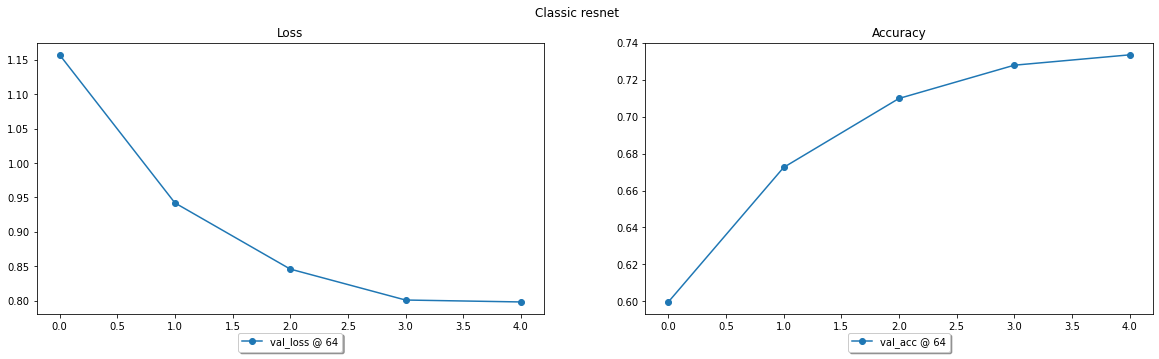

In [83]:
plot_metrics(m_r18)
plt.suptitle("Classic resnet")

In [55]:
cond_r18 = cond_resnet18()
m_cr18 = train_net(cond_r18, 5)


Text(0.5, 0.98, 'Conditional resnet')

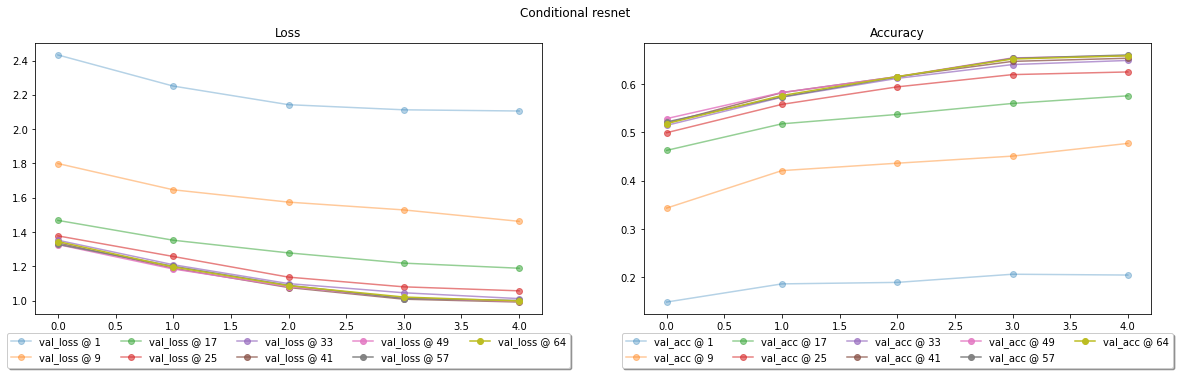

In [88]:
plot_metrics(m_cr18)
plt.suptitle("Conditional resnet")